# Tarefa 5 - Aprendizado de Máquina 2023.02
Aluno: Diego Vasconcelos Schardosim de Matos - 120098723

Esta tarefa épara ser reailizada com o dataset IRIS. 

0. Separar 80% dos dados para treinamento e 20% para teste. Esse conjunto de teste será usado apenas no final de todo o trabalho. O conjunto de treino e teste deve ser balanceado (mesmo número de instâncias de cada classe).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("./iris.csv")
df.head()

,sepalLengthInCM,sepalWidthInCM,petalLengthInCM,petalWidthInCM,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.shape

(150, 5)

In [4]:
Y = df['target']
X = df.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

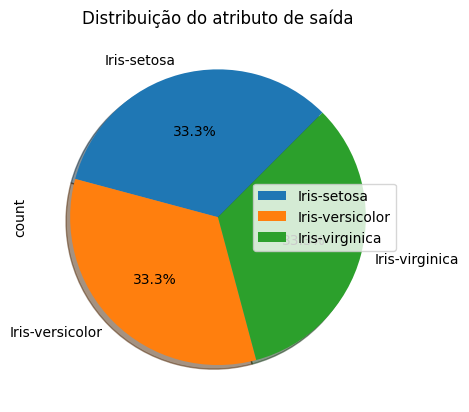

In [5]:
df['target'].value_counts().plot.pie(autopct='%3.1f%%', shadow=True, legend=True, startangle=45)
plt.title('Distribuição do atributo de saída')
plt.show()

O dataset está bem distribuído

1. Para os 80% restantes, você vai usar K-fold com K = 5, para várias arquiteturas da rede neural.

In [6]:
kf = KFold(n_splits=5)

2. Inicialmente, utilize todas as variávéis de entrada do dataset.
3. Utilize o classificador multi perceptron MLPClassifier com os seguintes valores:
- função de ativação: ‘logistic’, ‘tanh’, ‘relu’
- solver: ‘sgd’
- os outros parâmetros devem ser os que são default.
- o número de camadas e neurônios por camada ficam a seu critério
4. Para cada fold:
- informe o score de treinamento e teste
- plote um gráfico com o comportamento da função de perda. Você pode plotar em um gráfico só, todas as funções de perda.

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [8]:
# TODO: Plotar um gráfico com o comportamento da função perda

for activation_function in ['logistic', 'tanh', 'relu']:
    print('=== Treinando com função de ativação: {} ==='.format(activation_function))

    acc_score = []
    model = MLPClassifier(activation=activation_function, solver='sgd')

    for train_index, test_index in kf.split(X):
        kf_x_train, kf_x_test = X.iloc[train_index,:], X.iloc[test_index,:]
        kf_y_train, kf_y_test = Y[train_index], Y[test_index]

        model.fit(kf_x_train, kf_y_train)
        pred_values = model.predict(kf_x_test)

        acc = accuracy_score(pred_values, kf_y_test)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score) / 5

    print('Resultados do treinamento')  
    print('Accuracy of each fold: {}'.format(acc_score))
    print('Avg accuracy: {}'.format(avg_acc_score))


=== Treinando com função de ativação: logistic ===


c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Resultados do treinamento
Accuracy of each fold: [0.0, 0.0, 0.0, 0.06666666666666667, 0.0]
Avg accuracy: 0.013333333333333332
=== Treinando com função de ativação: tanh ===


c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Resultados do treinamento
Accuracy of each fold: [1.0, 1.0, 0.0, 0.9666666666666667, 0.0]
Avg accuracy: 0.5933333333333334
=== Treinando com função de ativação: relu ===


c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultados do treinamento
Accuracy of each fold: [1.0, 0.8666666666666667, 0.0, 1.0, 0.0]
Avg accuracy: 0.5733333333333334


c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


5. Analise o que ocorreu. 

Usando a técnica de reamostragem do K-Fold Cross Validation e o modelo de treinamento de Redes Neurais com funções de ativação igual a Logistica, Tanh ou Relu no aprendizado dos pesos de cada neuronio (backpropagation), o modelo não conseguiu convergir para uma solução dentro do limite máximo de 200 iterações.

6. Ainda usando os 80% dos dados e K-fold=5, repita o experimento alterados os parâmetros anteriores. A escolha de qual(is) parâmetro(s) será(ão) alterados deve ser justificado. O que você espera alterando o(s) parâmetro(s)? O resultado obtido foi o esperado?

Me vem em mente alterar quatro parametros:
- Taxa de aprendizado: O valor da taxa de aprendizado padrão é muito baixo (0.0001) fazendo com que demore para convergir, penso em deixa-lo 100x maior
- Limite de iterações: Aumentar o limite máximo de iterações do modelo
- Diminuir o numero de neuronios da rede para deixa-la mais simples. Pode ser que não precise de todos os 100 (valor padrão da biblioteca)
- De acordo com a documentação da biblioteca, usar o método solver='lbfgs' converge melhor a para dataset pequenos. Como nosso caso possui apenas 150 instancias, estarei testando com ele

In [9]:
# TODO: Plotar um gráfico com o comportamento da função perda

for activation_function in ['logistic', 'tanh', 'relu']:
    print('=== Treinando com função de ativação: {} ==='.format(activation_function))

    acc_score = []
    model = MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=1000, activation=activation_function, solver='lbfgs')

    for train_index, test_index in kf.split(X):
        kf_x_train, kf_x_test = X.iloc[train_index,:], X.iloc[test_index,:]
        kf_y_train, kf_y_test = Y[train_index], Y[test_index]

        model.fit(kf_x_train, kf_y_train)
        pred_values = model.predict(kf_x_test)

        acc = accuracy_score(pred_values, kf_y_test)
        acc_score.append(acc)

    avg_acc_score = sum(acc_score) / 5

    print('Resultados do treinamento')  
    print('Accuracy of each fold: {}'.format(acc_score))
    print('Avg accuracy: {}'.format(avg_acc_score))


=== Treinando com função de ativação: logistic ===
Resultados do treinamento
Accuracy of each fold: [1.0, 1.0, 0.8333333333333334, 0.8666666666666667, 0.7666666666666667]
Avg accuracy: 0.8933333333333333
=== Treinando com função de ativação: tanh ===
Resultados do treinamento
Accuracy of each fold: [1.0, 1.0, 0.8666666666666667, 0.9666666666666667, 0.8333333333333334]
Avg accuracy: 0.9333333333333333
=== Treinando com função de ativação: relu ===
Resultados do treinamento
Accuracy of each fold: [1.0, 1.0, 0.8666666666666667, 0.9333333333333333, 0.8]
Avg accuracy: 0.9199999999999999


Como esperado, alterando os parametros mencionados conseguimos uma convergencia rápida e uma boa acurácia.

7- Após terminar todos os experientos, escolha o modelo gerado que você considera o melhor resultado. Usando os parâmetros deste modelo, faça um novo treinamento usando todos os 80% dos dados.

In [10]:
model = MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=1000, activation='tanh', solver='lbfgs')
model.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(10,),
              learning_rate_init=0.01, max_iter=1000, solver='lbfgs')

8- Avalie o modelo gerado no item 8 usando as 15 instâncias que não foram usadas. 

In [11]:
pred_values = model.predict(X_test)
acc = accuracy_score(pred_values, y_test)

print('Resultados do treinamento')
print('Acurácia: {}'.format(acc))

Resultados do treinamento
Acurácia: 0.9666666666666667
